In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import os

from BNS_JT import cpm, variable

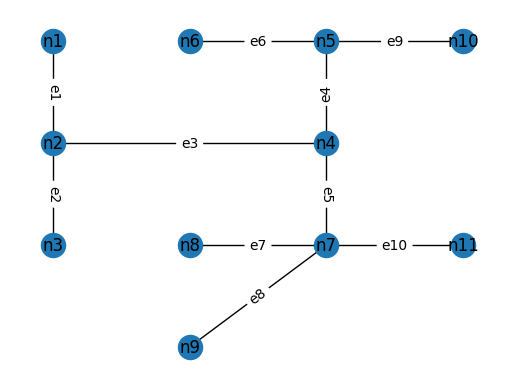

In [18]:
HOME = os.getcwd()

node_coords = {'n1': (0, 1),
                'n2': (0, 0),
                'n3': (0, -1),
                'n4': (2, 0),
                'n5': (2, 1),
                'n6': (1, 1),
                'n7': (2, -1),
                'n8': (1, -1),
                'n9': (1, -2),
                'n10': (3, 1),
                'n11': (3, -1)}

no_node_st = 2 # Number of a node's states
node_st_cp = [0, 2] # state index to actual capacity (e.g. state 1 stands for flow capacity 2, etc.)
varis = {}
for k, v in node_coords.items():
    varis[k] = variable.Variable( name=k, B = np.eye( no_node_st ), values = node_st_cp )

arcs = {'e1': ['n1', 'n2'],
        'e2': ['n2', 'n3'],
        'e3': ['n2', 'n4'],
        'e4': ['n4', 'n5'],
        'e5': ['n4', 'n7'],
        'e6': ['n5', 'n6'],
        'e7': ['n7', 'n8'],
        'e8': ['n7', 'n9'],
        'e9': ['n5', 'n10'],
        'e10': ['n7', 'n11']}

arcs_inds = { }
ind = 0
for e in arcs:
    ind += 1
    arcs_inds[e] = ind

no_arc_st = 3 # Number of an arc's states
arc_st_cp = [0, 1, 2] # state index to actual capacity (e.g. state 0 stands for flow capacity 0, etc.)
for k, v in arcs.items():
    varis[k] = variable.Variable( name=k, B = np.eye( no_arc_st ), values = arc_st_cp )

# subsystems information
no_sub = 2
subs = ['sub' + str( int(i+1) ) for i in range(no_sub)] # linear progression is assumed sub1 --> sub2 --> ...
sub_nodes = [['n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9'],
                ['n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n11']] # nodes in subsystem
sub_edges = [['e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', 'e8'],
                ['e4', 'e5', 'e6', 'e7', 'e8', 'e9', 'e10']] # edges in subsystem
orig = {'sub1': ['n1', 'n3'], 'sub2': ['n6', 'n8', 'n9']}
dest = {'sub1': ['n6', 'n8', 'n9'], 'sub2': ['n10', 'n11']}


depots = [['n1', 'n3'], ['n6', 'n8', 'n9'], ['n10', 'n11']] # nodes that flows must stop by


G = nx.Graph()
for k, x in arcs.items():
    G.add_edge(x[0], x[1], label=k)

for k, v in node_coords.items():
    G.add_node(k, pos=v, label = k)

pos = nx.get_node_attributes(G, 'pos')
edge_labels = nx.get_edge_attributes(G, 'label')

fig = plt.figure()
ax = fig.add_subplot()
nx.draw(G, pos, with_labels=True, ax=ax)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax)
fig.savefig( os.path.join(HOME, 'graph_toy.png'), dpi=200)



In [23]:
import scipy.optimize
# scipy.optimize.milp to be used

# cost function
## decision variables (x, u, v), where x are flows on arcs, u are flows from sources, and v are flows to terminals.
no_x = 2*len(arcs) # both directions are modelled, e.g. (x12, x21, x13, x31, ...)

orig_end = orig[subs[0]]
dest_end = dest[subs[-1]]

orig_end_inds = {}
ind = 0
for n in orig_end:
    ind += 1
    orig_end_inds[n] = ind

dest_end_inds = {}
ind = 0
for n in dest_end:
    ind += 1
    dest_end_inds[n] = ind

no_u = len( orig_end )
no_v = len( dest_end )

no_d_vars = no_x + no_u + no_v

# Cost function
c = np.zeros( (no_d_vars,) )
c[no_x:(no_x+no_u)] = 1



In [20]:
print(orig_end)

['n1', 'n3']


In [46]:
# constraints

## Depends on component vector state
### Example 1: all in the highest state
comps_st = {n: len(varis[n].B[0]) for n in node_coords}
for e in arcs:
    comps_st[e] = len(varis[e].B[0])


## Constraint matrices
A = np.empty(shape = (0,no_d_vars))
b_up = np.empty(shape=(0,))
b_down = np.empty(shape=(0,))

### Origins
for o_i in orig_end:
    a_i = np.zeros((1,no_d_vars))
    a_i[0][no_x + orig_end_inds[o_i] - 1] = -1

    for e, p in arcs.items():

        e_ind = arcs_inds[e]

        if p[0] == o_i:        
            a_i[0][ 2*(e_ind-1) ] = 1
            a_i[0][ 2*(e_ind-1) + 1 ] = -1
        
        elif p[1] == o_i:
            a_i[0][ 2*(e_ind-1) ] = -1
            a_i[0][ 2*(e_ind-1) + 1 ] = 1

    A = np.append(A, a_i, axis = 0)
    b_up = np.append(b_up, np.array(0))
    b_down = np.append(b_down, np.array(0))

### intermediate stations
##############231023


In [47]:
print(A)
print(b_up)
print(b_down)

[[ 1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0. -1.  0.  0.  0.]
 [ 0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0. -1.  0.  0.]]
[0. 0.]
[0. 0.]


In [14]:
print(comps_st)

{'n1': 2, 'n2': 2, 'n3': 2, 'n4': 2, 'n5': 2, 'n6': 2, 'n7': 2, 'n8': 2, 'n9': 2, 'n10': 2, 'n11': 2, 'e1': 3, 'e2': 3, 'e3': 3, 'e4': 3, 'e5': 3, 'e6': 3, 'e7': 3, 'e8': 3, 'e9': 3, 'e10': 3}
